In [1]:
import torch

import torchvision
import torchvision.transforms as transforms

In [2]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

dev

device(type='cuda')

In [35]:
transform_train = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     # transforms Normalize ( (R_mean, G_mean, B_mean), (R_std, G_std, B_std) )
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     # transforms Normalize ( (R_mean, G_mean, B_mean), (R_std, G_std, B_std) )
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [36]:
print(trainset)

print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [37]:
data = iter(trainloader)
x, y = data.next()
print(x.shape)

torch.Size([64, 3, 32, 32])


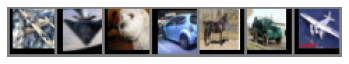

plane plane   dog   car horse truck plane


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('Off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:7]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(7)))

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class convModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Conv2D(in_channels, out_channels, kernel_size, ...)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)

        self.conv4 = nn.Conv2d(128, 128, 3)
        self.conv5 = nn.Conv2d(128, 128, 3)
        
        # MaxPool2D(kernel_size, stride, ...)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.4)

        
        self.fc1 = nn.Linear(4 * 4 * 128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 84)
        self.fc4 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        #x = self.maxpool(self.conv2(x))
        x = self.conv2(x)
        x = self.maxpool(self.conv3(x))
        x = F.relu(x)

        x = self.conv4(x)
        x = self.maxpool(self.conv5(x))
        x = F.relu(x)
        
        x = torch.flatten(x, 1)

        x = self.dropout2(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)

        x = F.relu(self.fc2(x))
        x = self.dropout1(x)

        x = F.relu(self.fc3(x))
        x = self.dropout1(x)

        x = self.fc4(x)
        
        return x
        

In [40]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(len(testloader))
print(len(trainloader))

157
782


In [41]:
def density(net):
  non_zero = 0
  count = 0
  with torch.no_grad():
      for p in net.parameters():
        #flatted_weights = torch.flatten(p)
        non_zero += torch.count_nonzero(p).cpu().numpy()
        count += torch.numel(p)

  #print("non zero: ", non_zero)
  #print("count: ", count)
  return non_zero / count


In [61]:
# fit pruning
# return list of loss, acc
def fit_pruning(net, optimizer, epochs, gamma, loss_fn, train_dl, test_dl, b=8):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    densities = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        test_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0

        # TRAIN
        for i, data in enumerate(train_dl):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(dev), data[1].to(dev)

            # forward
            outputs = net(inputs)
            
            # loss calculation
            loss = loss_fn(outputs, labels)
            
            # loss backward. grads are generated here
            loss.backward()
            
            # update weights
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()

            # >>> PRUNING <<<
            if gamma > 0.0:
                for p in net.parameters():
                    #previous = p.clone().detach();
                    
                    with torch.no_grad():
                        # transformando o layer em um vetor unidimensional 
                        flatted_weights = torch.flatten(p)
    
                        # calculando o desvio padrao
                        std = torch.std(flatted_weights, -1)
    
                        # calculando o beta para a camada
                        beta = gamma * std                        
                        
                        # mascara booleana, que indica qual peso devera ser mantido
                        mask = torch.gt(p.abs(), torch.ones_like(p) * beta)
                        
                        # multiplicando os pesos da camada pelo tensor booleano
                        p.multiply_(mask)
                        #p[torch.logical_not(boolean)] = 0;
    
                        # >>> QUANTIZATION <<<
                        #qk_prime = (torch.max(torch.abs(p)) - beta) / ( 2**(b - 1) - 1 )
                        #torch.round(p/qk_prime, out=p)
                        #p.multiply_(qk_prime)
                        #C[k] = torch.round(P[k]/qk_prime) * qk_prime
    
                        #  >>> SHOW NORM DISTANCE 
                        #print(torch.norm(p - previous))
                        #p.multiply_(pruned_weights)

                        
            #print("loss: ", loss.clone().detach())
                
            train_loss += loss.item()  
            train_acc += accuracy(outputs, labels)
        
        # TEST
        for i, data in enumerate(test_dl):
            inputs, labels = data[0].to(dev), data[1].to(dev)

            with torch.no_grad():
              outputs = net(inputs)
            test_loss += loss_fn(outputs, labels).item()
            test_acc += accuracy(outputs, labels)
            
        train_loss /= 782.
        train_acc /= 782.
        test_loss /= 157.
        test_acc /= 157.
        dst = density(net)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        densities.append(density(net))
        
        print('Epoch: %d/%d \
               train loss: %.3f \
               train accuracy: %.3f \
               test accuracy: %.3f \
               density: %.3f' %
            (epoch + 1, epochs, train_loss, train_acc, test_acc, dst)) # 782 == total of train batches
        

    print('Finished Training')
    return train_losses, train_accuracies, test_losses, test_accuracies, densities 

In [ ]:
from statistics import mean
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

#net_nopruning.to(dev)
#data = fit_pruning(net_nopruning, 50, 0.0, criterion, trainloader, testloader)

#print("no pruning accuracy: %.3f" % torch.max(torch.Tensor(data[3])))
#print("no pruning density: %.5f" % density(net_nopruning))

net_p05 = convModel()
optimizer = optim.Adam(net_p05.parameters(), lr=0.001)
print(net_p05)
net_p05.to(dev)
data = fit_pruning(net_p05, optimizer, 200, 0.0, criterion, trainloader, testloader)
print("pruning gamma 0.5 accuracy: %.3f" % torch.max(torch.Tensor(data[3])))
print("pruning gamma 0.5 density: %.5f" % torch.min(torch.Tensor(data[4])))

#net_p10.to(dev)
#data = fit_pruning(net_p10, 100, 1.0, criterion, trainloader, testloader)
#print("pruning gamma 1.0 accuracy: %.3f" % torch.max(torch.Tensor(data[3])))
#print("pruning gamma 1.0 density: %.5f" % density(net_p10))

#net_p15.to(dev)
#data = fit_pruning(net_p15, 140, 1.5, criterion, trainloader, testloader)
#print("pruning gamma 1.5 accuracy: %.3f" % torch.max(torch.Tensor(data[3])))
#print("pruning gamma 1.5 density: %.5f" % density(net_p15))

convModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (dropout2): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
Epoch: 1/200                train loss: 1.771                train accuracy: 0.335                test accuracy: 0.466                density: 1.000
Epoch: 2/200                train loss: 1.469                train accuracy: 0.477                test 

In [63]:
import pandas as pd

def save_experiment(net, log, parameters):
    train_losses, train_accuracies, test_losses, test_accuracies, densities = log
    net_name = 'gamma' + parameters['gamma'] + 'acc' + str(max(test_accuracies).cpu().numpy())[:4] + 'dst' + str(max(densities))[:4]


    df = pd.DataFrame({
        'loss': train_losses,
        'test_accuracy': list(map(lambda x: x.cpu().numpy(), test_accuracies)),
        'density': densities
    })

    df['epoch'] = range(1, len(train_losses) + 1)
    df.to_csv(net_name + '.csv')

    torch.save(net, net_name + '.pth')

save_experiment(net_p05, data, {'gamma': '0.5'})

In [ ]:
#torch.save(net_nopruning, './models/no_pruning/model.pth')
print(density(net_p05))
torch.save(net_p05, './pruning_gamma05.pth')


#torch.save(net_p10, './models/pruning_gamma10/model.pth')

#torch.save(net_p15, './models/pruning_gamma15/model.pth')

non zero:  tensor(42162, device='cuda:0')
count:  1591270
tensor(0.0265, device='cuda:0')


In [ ]:
import matplotlib.pyplot as plt

